#### Demonstration of HMC sampling and traditional MH sampling, samplers defined in ```utils/mcmc.py```

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import mcmc
ds = tf.contrib.distributions

#### Target Distribution

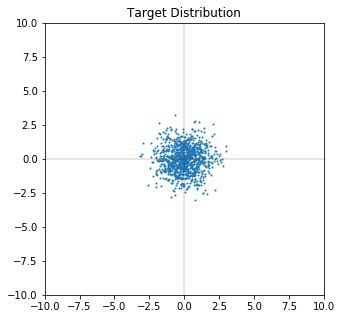

In [2]:
dist = ds.MultivariateNormalTriL(loc=[0.0, 0.0], scale_tril=tf.cholesky(tf.constant([[1.0, 0], [0, 1.0]])))
with tf.Session() as sess:
    target = sess.run(dist.sample(1000))
    
plt.figure(figsize=(5, 5))
plt.scatter(target[:, 0], target[:, 1], s=1.)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title("Target Distribution")
plt.axhline(y=0, color='k', linewidth=0.2)
plt.axvline(x=0, color='k', linewidth=0.2)
plt.show()

#### Hamilton dynamics

Assume that momentum $p$, position $x$, potential energy $U(x)$ and kinetic energy $K(p)$. The Hamiltonian is given by $H(x, p)=U(x)+K(p)$, satisfying the following
$$-\frac{\partial{H(x, p)}}{\partial{\vec{x_i}}}=-\frac{\partial{U(x)}}{\partial{\vec{x_i}}}=\frac{\partial{\vec{p_i}}}{\partial{t}}$$
$$\frac{\partial{H(x, p)}}{\partial{\vec{p_i}}}=\frac{\partial{K(p)}}{\partial{\vec{p_i}}}=\frac{\partial{\vec{x_i}}}{\partial{t}}$$

The first equation is derived by Newton's second law $F=ma$, where $m$ the mass and $a$ the acceleration. Note that for potential energy, the direction of the force is opposite to its position vector, hence $-\frac{\partial{U(x)}}{\partial{\vec{x_i}}}=ma$. The second equation is derived by computing the velocity.

#### Leapfrog (derived via second-order Taylor expansion or decomposing the Hamiltonian)
$$p_i(t+\varepsilon/2)=p_i(t)-(\varepsilon/2)\frac{\partial{U}}{\partial{x_i}}(x(t))$$

$$x_i(t+\varepsilon)=x_i(t)+\varepsilon \frac{p_i(t+\varepsilon/2)}{m_i}$$

$$p_i(t+\varepsilon)=p_i(t+\varepsilon/2) - (\varepsilon/2)\frac{\partial{U}}{\partial{x_i}}(x(t+\varepsilon))$$

In [3]:
#HMC hyperparameters
hmc_state = tf.get_variable("hmc_state", shape=[1000, 2], initializer=tf.random_normal_initializer(mean=10.))

def u(x):
    return  tf.reduce_sum(x * x, axis=-1) / 2.0

def k(p):
    return  tf.reduce_sum(p * p, axis=-1) / 2.0

def minus_energy(x, p):
    return - (u(x) + k(p))

In [4]:
# Metropolis Hastings hyperparameters
mh_state = tf.get_variable('mh_state', shape=[1000, 2], initializer=tf.random_normal_initializer(mean=10.))

# Unnormalized prob
def log_density(x):
    return  - tf.reduce_sum(x * x, axis=-1) / 2.0

def random_proposal(x):
    return (x + tf.random_uniform(tf.shape(x), minval=-1, maxval=1.))


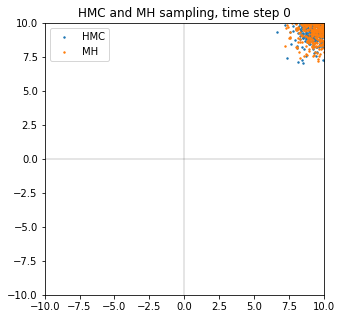

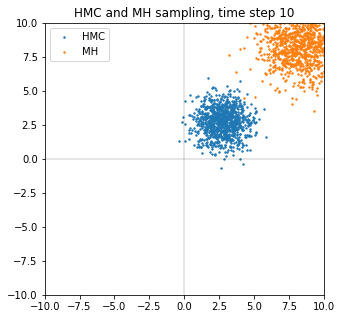

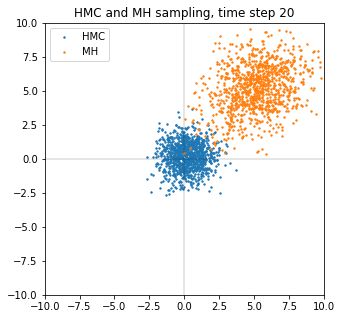

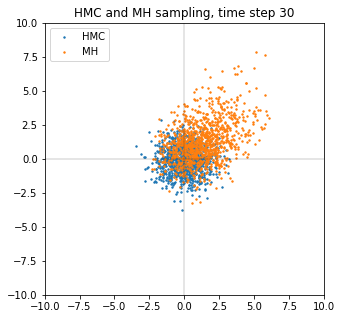

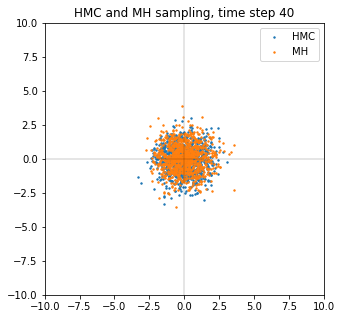

In [5]:
hmc_sampler = mcmc.HMC_sampler(hmc_state, tf.random_normal, u, k, 0.1, 5)
mh_sampler = mcmc.metropolis_hastings_sampler(random_proposal, mh_state, log_density)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for i in range(5):
    sess.run(hmc_sampler.run(10 * i))
    sess.run(mh_sampler.run(10 * i))
    hmc_samples = sess.run(hmc_state)
    mh_samples = sess.run(mh_state)
    #print samples
    plt.figure(figsize=(5, 5))
    plt.scatter(hmc_samples[:, 0], hmc_samples[:, 1], s=2., label="HMC")
    plt.scatter(mh_samples[:, 0], mh_samples[:, 1], s=2., label="MH")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.title("HMC and MH sampling, time step %d" % (i*10))
    plt.axhline(y=0, color='k', linewidth=0.2)
    plt.axvline(x=0, color='k', linewidth=0.2)
    plt.legend()
    plt.show()
    
sess.close()